# 한글 Word2Vec 만들기

- 한글로 된 코퍼스를 다운받아 전처리를 수행
- 전처리한 데이터를 바탕으로 Word2Vec 작업을 진행
- [영어/한국어 Word2Vec 실습](https://wikidocs.net/50739)

In [1]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 1.4MB/s 
     |████████████████████████████████| 460kB 53.5MB/s 
     |████████████████████████████████| 92kB 13.5MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [13]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7f567e20c6d0>)

In [14]:
train_data = pd.read_table('ratings.txt')
train_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [15]:
print(len(train_data), train_data.isnull().values.any()) # 리뷰 개수 출력, NULL 값 존재 유무

200000 True


In [16]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(len(train_data), train_data.isnull().values.any()) # 리뷰 개수 출력, Null 값이 존재하는지 확인

199992 False


In [17]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [19]:
import tqdm.notebook as tn

# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()
tokenized_data = []
for sentence in tn.tqdm(train_data['document']):
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    tokenized_data.append(temp_X)

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


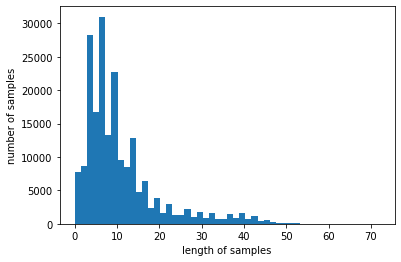

In [20]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [21]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [22]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(16477, 100)

In [23]:
print(model.wv.most_similar("최민식"))

[('이정재', 0.8787218928337097), ('안성기', 0.8573732376098633), ('김명민', 0.8537412285804749), ('한석규', 0.8516954779624939), ('단역', 0.8493001461029053), ('이미숙', 0.8414855599403381), ('김창완', 0.8344323635101318), ('우성', 0.8336575627326965), ('김수현', 0.8335291147232056), ('최민수', 0.8317939043045044)]


In [24]:
print(model.wv.most_similar("히어로"))

[('슬래셔', 0.8673124313354492), ('무협', 0.8572776317596436), ('호러', 0.8545657396316528), ('느와르', 0.8492067456245422), ('정통', 0.8218570947647095), ('블록버스터', 0.8212387561798096), ('물', 0.8101167678833008), ('무비', 0.809351921081543), ('물의', 0.8037816286087036), ('재난영화', 0.7978581190109253)]


In [25]:
!ls -l

total 19064
-rw-r--r-- 1 root root 19515078 Feb 24 01:16 ratings.txt
drwxr-xr-x 1 root root     4096 Feb 22 14:38 sample_data
